In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import math
'''-------------------------Empty cache and check devices-------------------------'''
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)


# 定义网络模型
def get_omega_points(num, x_left=0.0, y_left=0.0, x_right=1.0, y_right=1.0, z_left = 0.0, z_right = 1.0):
    
    # 生成 num 个 x 坐标，范围在 [x_left, x_right]
    x_coords = torch.rand(num, 1) * (x_right-x_left) + x_left
    # 生成 num 个 y 坐标，范围在 [y_left, y_right]
    y_coords = torch.rand(num, 1) * (y_right-y_left) + y_left
    # 拼接 x 和 y 坐标形状为 (num，形成, 2) 的张量
    z_coords = torch.rand(num, 1) * (z_right-z_left) + z_left
    points = torch.cat([x_coords, y_coords, z_coords], dim=1)
    return points

def get_sphere_surface_points(
    num: int, 
    center: torch.Tensor, 
    radius: float = 0.2
) -> torch.Tensor:
    
    # 2. 生成均匀分布的角度
    # 为了在球面上均匀分布，极角 theta 需要特殊处理
    # z = cos(theta)，我们从均匀分布中采样 z
    z = torch.linspace(1.0 - 1e-6, -1.0 + 1e-6, num, dtype=torch.float32, device=center.device)
    theta = torch.acos(z)  # 极角，范围 [0, π]

    # 方位角 phi 可以从均匀分布中采样
    phi = 2 * torch.pi * torch.rand(num, dtype=torch.float32, device=center.device) # 范围 [0, 2π)

    # 3. 利用球面坐标到笛卡尔坐标的转换公式计算点
    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    sin_phi = torch.sin(phi)
    cos_phi = torch.cos(phi)

    x = radius * sin_theta * cos_phi
    y = radius * sin_theta * sin_phi
    z_coord = radius * cos_theta

    # 4. 将坐标与球心相加，并拼接成 (num, 3) 的输出张量
    sphere_points = torch.stack([x, y, z_coord], dim=1) + center

    return sphere_points
    

def get_cube_boundary_points(num: int) -> torch.Tensor:
    """
    生成三维 [0, 1]^3 立方体的边界点。
    
    参数:
        num (int): 生成的边界点总数。必须是6的倍数，以保证每个面的点数相等。
    
    返回:
        torch.Tensor: 边界点张量，形状为 (num, 3)，每一行对应一个 (x, y, z) 坐标。
    
    异常:
        ValueError: 若 num 不是6的倍数，则抛出异常。
    """
    # 1. 输入合法性校验
    if num % 6 != 0:
        raise ValueError(f"点数量 'num' 必须是6的倍数，以确保每个面有相同数量的点，当前为 {num}")

    # 计算每个面的点数量
    points_per_face = num // 6

    # 使用 torch.rand 生成 [0, 1) 范围内的随机坐标
    rand_coords_1 = torch.rand(points_per_face)
    rand_coords_2 = torch.rand(points_per_face)

    # --- 生成6个面的边界点 ---
    
    # 1. x = 0 面
    face_x0 = torch.stack([torch.zeros_like(rand_coords_1), rand_coords_1, rand_coords_2], dim=1)
    
    # 2. x = 1 面
    face_x1 = torch.stack([torch.ones_like(rand_coords_1), rand_coords_1, rand_coords_2], dim=1)
    
    # 3. y = 0 面
    face_y0 = torch.stack([rand_coords_1, torch.zeros_like(rand_coords_1), rand_coords_2], dim=1)
    
    # 4. y = 1 面
    face_y1 = torch.stack([rand_coords_1, torch.ones_like(rand_coords_1), rand_coords_2], dim=1)
    
    # 5. z = 0 面
    face_z0 = torch.stack([rand_coords_1, rand_coords_2, torch.zeros_like(rand_coords_1)], dim=1)
    
    # 6. z = 1 面
    face_z1 = torch.stack([rand_coords_1, rand_coords_2, torch.ones_like(rand_coords_1)], dim=1)

    # 拼接所有边界点
    all_points = torch.cat([face_x0, face_x1, face_y0, face_y1, face_z0, face_z1], dim=0)

    return all_points

def alpha_x(x_op, radius: float = 0.2) -> torch.Tensor:
    
    # 确保输入是一维的
    x = x_op[:,0].flatten()
    y = x_op[:,1].flatten()
    z = x_op[:,2].flatten()
    # 四个角落的中心坐标（转为 NumPy 数组用于计算）
    centers = np.array([
        [0.2, 0.2, 0.2],  
        [0.2, 0.2, 0.8],  
        [0.2, 0.8, 0.2],  
        [0.2, 0.8, 0.8],
        [0.8, 0.2, 0.2],  
        [0.8, 0.2, 0.8],  
        [0.8, 0.8, 0.2],  
        [0.8, 0.8, 0.8]  
    ])
    # 将输入的 x, y 转为 NumPy 数组
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    z_np = z.detach().cpu().numpy()
    # 初始化 alpha 值为 0.018
    alpha_np = np.ones_like(x_np) * 0.018
    # 遍历每个角落中心，判断点是否在角落区域内
    for center in centers:
        # 计算每个点到当前角落中心的距离
        dist = np.sqrt((x_np-center[0])**2 + (y_np-center[1])** 2 + (z_np-center[2])**2)
        # 若距离小于半径，将对应位置的 alpha 值设为 137
        alpha_np[dist < radius] = 137.0
    # 将 NumPy 数组转回 PyTorch Tensor，并保持设备和数据类型与输入一致
    alpha_tensor = torch.tensor(alpha_np, dtype=x.dtype, device=x.device)
    return alpha_tensor

def f_x(x):
    f = torch.ones_like(x[:,0]) * 10
    return f

def u_x_boundary(x):
    u_b = torch.zeros_like(x[:,0])
    return u_b

def func_loss_o_rbf1(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_1(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf2(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_2(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf3(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_3(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf4(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_4(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf5(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_5(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf6(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_6(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf7(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_7(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_rbf8(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = rbf_model_8(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dy),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_o_nn(x_op: torch.Tensor, f_omega: torch.Tensor) -> torch.Tensor:
    output_op = model_nn(x_op)
    f_omega = f_omega.reshape(-1, 1)
    a = alpha_x(x_op.cpu()).to(device).reshape(-1, 1)
    grad_op = autograd.grad(outputs=output_op, inputs=x_op,
                            grad_outputs=torch.ones_like(output_op),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    du_dx = torch.unsqueeze(grad_op[:, 0],1)
    du_dy = torch.unsqueeze(grad_op[:, 1],1)
    du_dz = torch.unsqueeze(grad_op[:, 2],1)
    grad_op1 = autograd.grad(outputs=du_dx, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op2 = autograd.grad(outputs=du_dy, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dx),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_op3 = autograd.grad(outputs=du_dz, inputs=x_op,
                            grad_outputs=torch.ones_like(du_dz),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
    u_xx = torch.unsqueeze(grad_op1[:, 0],1)
    u_yy = torch.unsqueeze(grad_op2[:, 1],1)
    u_zz = torch.unsqueeze(grad_op3[:, 2],1)
    loss_op = a * (u_xx + u_yy + u_zz) + f_omega
    return loss_op

def func_loss_b_rbf1(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_1(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf2(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_2(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf3(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_3(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf4(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_4(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf5(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_5(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf6(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_6(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf7(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_7(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

def func_loss_b_rbf8(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = rbf_model_8(x_b)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

#计算边界上nn的loss
def func_loss_b_nn(x_b: torch.Tensor) -> torch.Tensor:
    g_omega = u_x_boundary(x_b).reshape(-1, 1)
    u = model_nn(x_b).reshape(-1, 1)
    loss_b = u - g_omega
    return torch.mean(loss_b**2)

'''-------------------------Define networks-------------------------'''
class NeuralNet_Shallow(torch.nn.Module):

    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output

    def __init__(self, in_dim, h_dim, out_dim):
        super(NeuralNet_Shallow, self).__init__()
        self.ln1 = nn.Linear(in_dim, h_dim)
        self.act1 = nn.Sigmoid()
        # self.act1 = nn.Tanh()
        # self.act1 = nn.ReLU()

        self.ln2 = nn.Linear(h_dim, out_dim, bias=False)

    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out
        
class NeuralNet_Deep(torch.nn.Module):

    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim, h_dim, out_dim, depth):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        self.list = nn.ModuleList()
        self.ln1 = nn.Linear(in_dim, h_dim)
        #self.act1 = nn.Sigmoid()
        self.act1 = nn.Tanh()
        # self.act1 = nn.ReLU()

        for i in range(self.depth):
            self.list.append(nn.Linear(h_dim, h_dim))

        self.lnd = nn.Linear(h_dim, out_dim, bias=False)

    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

# Network size of NN with RBF
n_input_rbf = 3
n_hidden_rbf = 80
n_output_rbf = 1
radius = 0.2
# number of training and test data points

centers = torch.tensor([
        [0.2, 0.2, 0.2],  
        [0.2, 0.2, 0.8],  
        [0.2, 0.8, 0.2],  
        [0.2, 0.8, 0.8],
        [0.8, 0.2, 0.2],  
        [0.8, 0.2, 0.8],  
        [0.8, 0.8, 0.2],  
        [0.8, 0.8, 0.8]  
    ])


def initialize_spherical_centers(num_centers: int, radius: float, center: torch.Tensor) -> torch.Tensor:
    """
    使用黄金螺旋算法，在指定球面上生成均匀分布的RBF中心点。

    参数:
        num_centers (int): 要生成的中心点数量。
        radius (float): RBF中心点所在球面的半径。
        center (torch.Tensor): RBF中心点所在球面的球心，形状为 (3,)。

    返回:
        torch.Tensor: 形状为 (num_centers, 3) 的张量，可直接用于初始化 nn.Parameter。
    """
    # 确保中心点是3D坐标
    if center.ndim != 1 or center.shape[0] != 3:
        raise ValueError(f"球心 'center' 必须是形状为 (3,) 的 torch.Tensor，当前形状为 {center.shape}")

    points = []
    # 黄金角，确保点的分布没有周期性
    phi = math.pi * (3.0 - math.sqrt(5.0)) 

    for i in range(num_centers):
        # 1. 在 [-1, 1] 范围内均匀采样 z 坐标
        y = 1.0 - (i / (num_centers - 1)) * 2.0  
        
        # 2. 计算在当前 z 高度上的圆的半径
        radius_at_y = math.sqrt(1.0 - y * y)
        
        # 3. 计算方位角，使用黄金角确保均匀分布
        theta = i * phi
        
        # 4. 将 (theta, y) 转换为笛卡尔坐标 (x, y, z)
        x = math.cos(theta) * radius_at_y
        z_coord = math.sin(theta) * radius_at_y
        
        points.append([x, y, z_coord])

    # 将列表转换为张量
    points_tensor = torch.tensor(points, dtype=torch.float32)

    # 5. 将单位球面上的点缩放并平移到目标球面
    points_tensor = points_tensor * radius + center

    return points_tensor

center_init_1 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[0]) 
center_init_2 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[1]) 
center_init_3 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[2]) 
center_init_4 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[3])
center_init_5 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[4]) 
center_init_6 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[5]) 
center_init_7 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[6]) 
center_init_8 =  initialize_spherical_centers(n_hidden_rbf, 0.2, centers[7])

rbf_model_1 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_1,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_2 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_2,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_3 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_3,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_4 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_4,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_5 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_5,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_6 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_6,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_7 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_7,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

rbf_model_8 = RBFLayer(in_features_dim=n_input_rbf,\
                   num_kernels=n_hidden_rbf,\
                   out_features_dim=n_output_rbf,\
                   constant_centers_parameter = False,\
                   initial_centers_parameter = center_init_8,\
#                    initial_shape_parameter = initial_shape,\
#                    initial_weights_parameters = initial_weights,\
                   radial_function=rbf_gaussian,\
                   norm_function=l_norm,\
                   normalization=False).double().to(device)

# Network size
n_input = 3
n_hidden = 20
n_output = 1
n_depth = 7  # only used in deep NN
num_omega = 10000
num_b = 600 #注意此处设置的为每个边取点数量
num_circle_b = 100
rate = 1e-2
epochs = 30000

# NN structure
if n_depth == 1:  # Shallow NN
	model_nn = NeuralNet_Shallow(n_input, n_hidden, n_output).double().to(device)
else:  # Deep NN
	model_nn = NeuralNet_Deep(n_input, n_hidden, n_output, n_depth).double().to(device)
model_nn.load_state_dict(torch.load('3d_best_model_first_LM.mdl'))
model_nn.eval() 
# 定义网格密度
n = 40
x1 = torch.linspace(0, 1, n)
x2 = torch.linspace(0, 1, n)
x3 = torch.linspace(0, 1, n)

# 生成三维网格坐标
# 使用 indexing='ij' 明确指定索引方式，这是 PyTorch 的默认方式
X, Y, Z = torch.meshgrid(x1, x2, x3, indexing='ij')

# --- 正确的做法：直接展平，不要使用 .T ---
# X.flatten(), Y.flatten(), Z.flatten() 会保持相同的顺序，从而保证 (x,y,z) 坐标一一对应
test_points = torch.cat(
    (
        X.flatten()[:, None], 
        Y.flatten()[:, None], 
        Z.flatten()[:, None]
    ), 
    dim=1
).to(device)

test_points.requires_grad = True
optimizer = torch.optim.Adam(model_nn.parameters(), lr = rate) 
best_l2, best_rel_l2, best_h2, best_L_infinity, best_epoch = 1000, 1000, 1000, 100,0
f_xo_nn = f_x(test_points).to(device)
loss_xo_nn = func_loss_o_nn(test_points, f_xo_nn)


device =  cuda


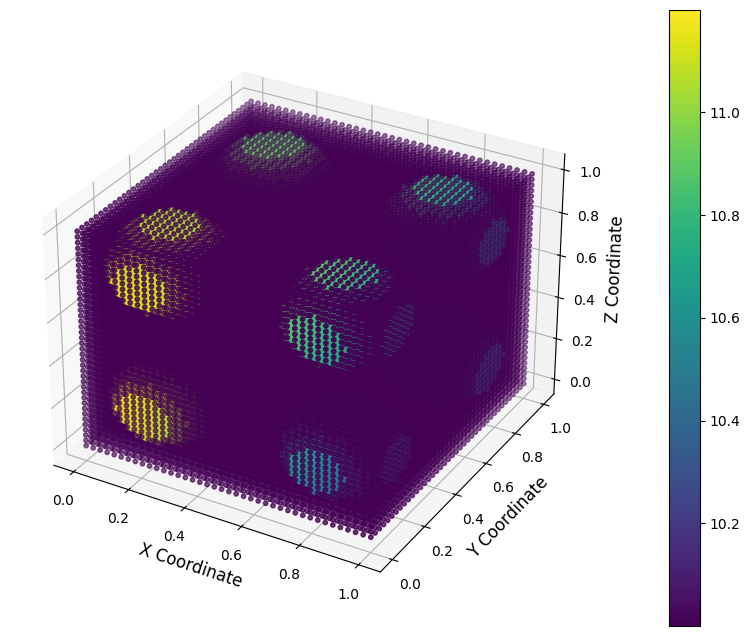

In [42]:
# 1. 准备数据：将 PyTorch Tensor 转换为 NumPy 数组
# 如果你的数据在 GPU 上，需要先用 .cpu() 移到 CPU
points_np = test_points.detach().cpu().numpy()
loss_np = loss_xo_nn.detach().cpu().numpy()

# 2. 创建 3D 图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3. 绘制散点图
# s: 散点的大小
# c: 散点的颜色，可以传入一个数组，这里用损失值
# cmap: 颜色映射方案，'viridis' 是一个常用的，也可以用 'jet', 'plasma', 'inferno', 'magma', 'cividis'
sc = ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], c=loss_np, s=10, cmap='viridis')

ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_zlabel('Z Coordinate', fontsize=12)

# 添加颜色条，显示颜色对应的损失值
cbar = fig.colorbar(sc, ax=ax, pad=0.1)

# 显示图形
plt.show()

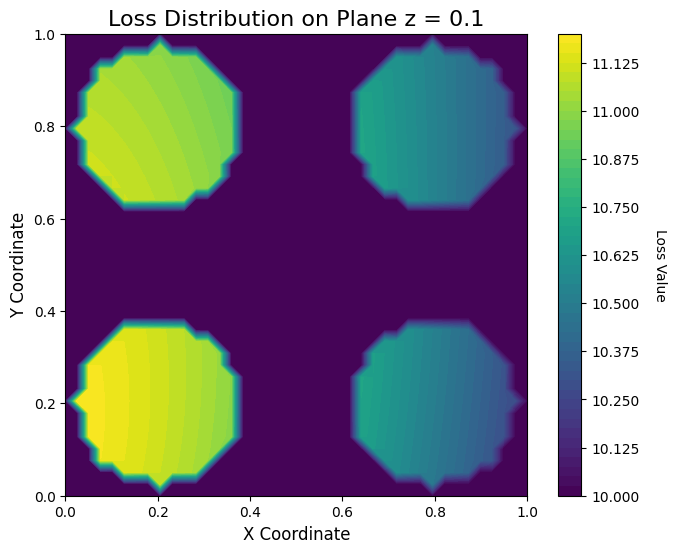

In [43]:

n = 40  # 与你定义的网格密度一致
loss_3d = loss_xo_nn.reshape(n, n, n)  # 从 (n³,1) 恢复为 (n,n,n)

# 2. 找到 z 轴上最接近 0.1 的索引（避免浮点数精度问题，不用 == 比较）
z_target = 0.1
# x3 是你生成的 z 轴坐标序列（torch.linspace(0,1,n)）
# 找到 x3 中最接近 z_target 的位置索引
z_index = torch.where(torch.isclose(x3, torch.tensor(z_target, device=x3.device)))[0]
# 若有多个接近值，取第一个（通常只有一个最接近值）
if len(z_index) == 0:
    # 若没有完全匹配的，取最接近的那个索引（用绝对值最小找）
    z_index = torch.argmin(torch.abs(x3 - z_target))
else:
    z_index = z_index[0]

# 3. 提取 z=z_target 平面的 2D 数据（切片操作）
# X_plane/Y_plane: z=z_target 平面的 X/Y 坐标（shape: (n,n)）
# loss_plane: z=z_target 平面的损失值（shape: (n,n)）
X_plane = X[:, :, z_index]  # 所有 x、所有 y，仅取 z=z_index 的层
Y_plane = Y[:, :, z_index]
loss_plane = loss_3d[:, :, z_index]  # 对应平面的损失

# 4. 转换为 NumPy 数组（matplotlib 不支持 PyTorch 张量）
# 注意：若数据在 GPU 上，需先移到 CPU 并 detach 脱离计算图
X_plane_np = X_plane.detach().cpu().numpy()
Y_plane_np = Y_plane.detach().cpu().numpy()
loss_plane_np = loss_plane.detach().cpu().numpy()

# 5. 绘制 z=0.1 平面的 2D 损失分布图（填充等高线图）
fig, ax = plt.subplots(figsize=(8, 6))

# contourf：绘制填充等高线图，levels 越多颜色过渡越平滑
# cmap 保持和 3D 图一致（viridis），确保颜色含义统一
contour = ax.contourf(
    X_plane_np,    # 平面的 X 坐标
    Y_plane_np,    # 平面的 Y 坐标
    loss_plane_np, # 平面的损失值
    levels=50,     # 等高线层数（越多越平滑）
    cmap='viridis' # 颜色映射（与 3D 图一致）
)

# 6. 美化图形（清晰展示坐标和损失对应关系）
ax.set_title(f'Loss Distribution on Plane z = {z_target}', fontsize=16)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_aspect('equal', adjustable='box')  # 保持 X/Y 轴比例一致，避免图形拉伸

# 添加颜色条（与 3D 图颜色含义统一）
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Loss Value', rotation=270, labelpad=20)  # 垂直显示标签

# 显示图形
plt.show()

pred_u_rbf shape =  (64000, 4)


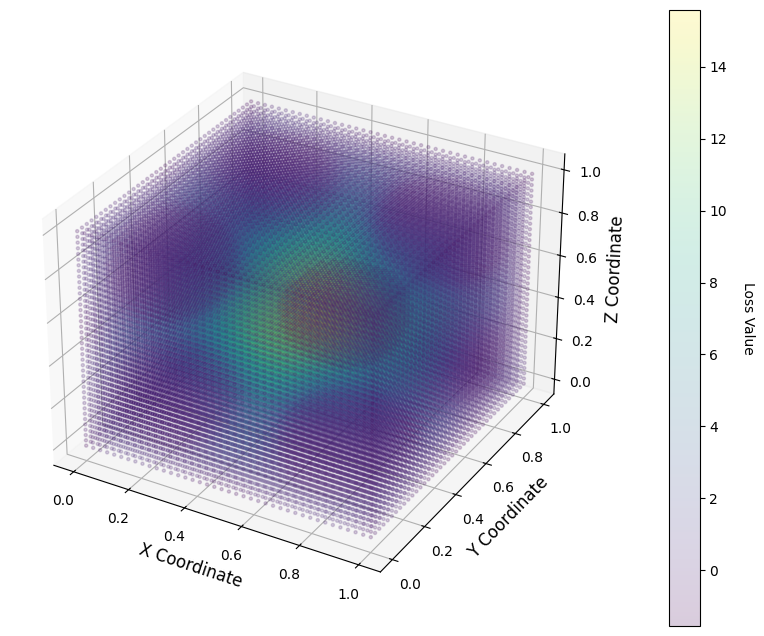

In [44]:

pred_u_rbf = np.loadtxt('3D_darcy_adam_prediction.txt')
print('pred_u_rbf shape = ', pred_u_rbf.shape)
# 2. 创建 3D 图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3. 绘制散点图
# s: 散点的大小
# c: 散点的颜色，可以传入一个数组，这里用损失值
# cmap: 颜色映射方案，'viridis' 是一个常用的，也可以用 'jet', 'plasma', 'inferno', 'magma', 'cividis'
# 绘制散点图时，增加 alpha（透明度，0~1，越小越透明）、减小 s（点大小）
sc = ax.scatter(
    pred_u_rbf[:, 0], 
    pred_u_rbf[:, 1], 
    pred_u_rbf[:, 2], 
    c=pred_u_rbf[:, 3], 
    s=5,        # 减小点大小（原可能是10，可根据需要调更小，如3）
    alpha=0.2,  # 增加透明度（0.1~0.5 之间试，平衡可见性和穿透性）
    cmap='viridis'
)

# 4. 美化图形
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_zlabel('Z Coordinate', fontsize=12)

# 添加颜色条，显示颜色对应的损失值
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Loss Value', rotation=270, labelpad=20)

pred_u_rbf shape =  (64000, 4)


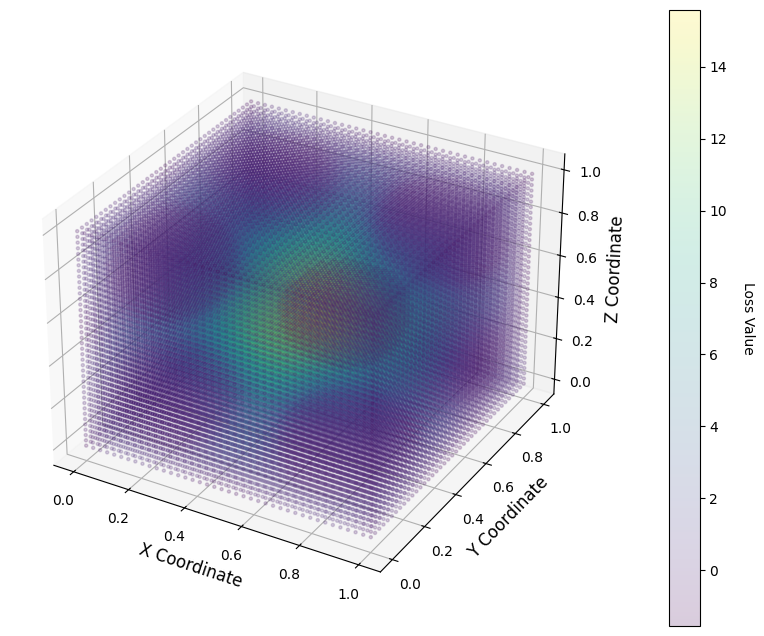

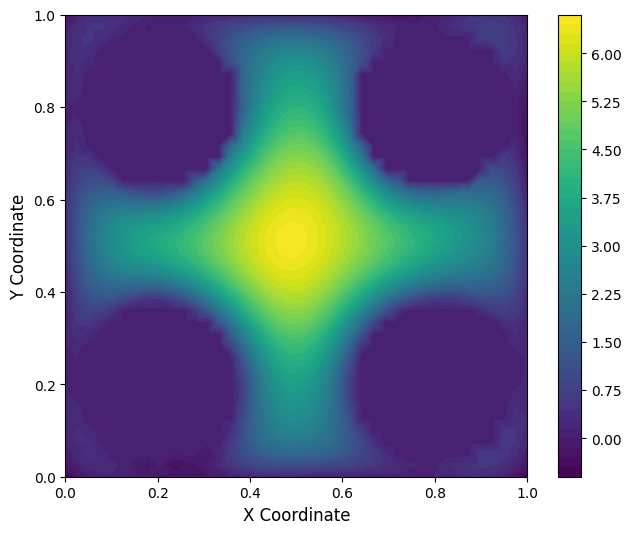

In [ ]:
pred_u_rbf = np.loadtxt('3D_darcy_adam_prediction.txt')
print('pred_u_rbf shape = ', pred_u_rbf.shape)

fig_3d = plt.figure(figsize=(10, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')

sc_3d = ax_3d.scatter(
    pred_u_rbf[:, 0], 
    pred_u_rbf[:, 1], 
    pred_u_rbf[:, 2], 
    c=pred_u_rbf[:, 3], 
    s=5,        
    alpha=0.2,  
    cmap='viridis'
)

ax_3d.set_xlabel('X Coordinate', fontsize=12)
ax_3d.set_ylabel('Y Coordinate', fontsize=12)
ax_3d.set_zlabel('Z Coordinate', fontsize=12)

cbar_3d = fig_3d.colorbar(sc_3d, ax=ax_3d, pad=0.1)
cbar_3d.set_label('Loss Value', rotation=270, labelpad=20)


# ------------------- 新增代码：生成 z=0.1 的剖面图 -------------------
# 1. 定义平面 z 值和容差（控制筛选范围）
z_target = 0.1
tolerance = 0.01  # 可根据数据密度调整，如0.005、0.02等

# 2. 筛选 z 坐标在 [z_target-tolerance, z_target + tolerance] 内的点
mask = (pred_u_rbf[:, 2] >= z_target-tolerance) & (pred_u_rbf[:, 2] <= z_target + tolerance)
plane_points = pred_u_rbf[mask]

if len(plane_points) == 0:
    print(f"警告：未找到 z 在 {z_target-tolerance} 到 {z_target + tolerance} 范围内的点，请调整容差！")
else:
    # 3. 提取平面上的 x、y 坐标和损失值
    x_plane = plane_points[:, 0]
    y_plane = plane_points[:, 1]
    loss_plane = plane_points[:, 3]

    # 4. 创建平面可视化图形
    fig_plane = plt.figure(figsize=(8, 6))
    ax_plane = fig_plane.add_subplot(111)

    # 5. 绘制三角剖分的填充等高线（适合不规则散点）
    contour = ax_plane.tricontourf(
        x_plane, 
        y_plane, 
        loss_plane, 
        levels=50,   # 等高线层数（越多越平滑）
        cmap='viridis'
    )
    ax_plane.set_xlabel('X Coordinate', fontsize=12)
    ax_plane.set_ylabel('Y Coordinate', fontsize=12)
    ax_plane.set_aspect('equal')  # 保持 x/y 轴比例，避免图形拉伸

    # 7. 添加颜色条（与3D图颜色映射一致）
    cbar_plane = fig_plane.colorbar(contour, ax=ax_plane)

# 显示所有图形
plt.show()

In [49]:
pred_u = torch.from_numpy(np.loadtxt('3D_darcy_adam_prediction.txt')[:, 3])
truth_u = torch.from_numpy(np.loadtxt('pred_u_FE_300.txt'))

In [ ]:
l2_loss = torch.sqrt(torch.mean(torch.pow(pred_u - truth_u, 2))) / torch.sqrt(
                    torch.mean(torch.pow(truth_u, 2)))
print(l2_loss)

torch.Size([64000])
tensor(0.1634)
